This notebook does basic Bayesian regression for $\delta^{18}O_c$.

In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pylab as plt
# import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smformula
import cartopy.crs as ccrs
import pymc3 as pm

/home/sbm/miniconda3/envs/deltaoxfox/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
coretop_path = './data_parsed/coretops-2017-09-27.csv'

# Read coretop data and parse

In [4]:
coretops_raw = pd.read_csv(coretop_path)

coretops_raw.sort_values('species', inplace=True)
coretops = coretops_raw.query('temp_ann > 0').copy()

This gives you an idea what the data looks like:

In [5]:
print(coretops.shape)
coretops.head()

(1094, 8)


,corename,species,latitude,longitude,d18oc,temp,temp_ann,d18osw
0,86.01,bulloides,53.40,-27.48,1.40,8.642266,10.468278,0.352871
410,GIK13534-1,bulloides,21.02,-17.88,-0.15,17.358565,18.429110,1.003336
869,KR88-10,bulloides,-54.19,144.78,2.73,1.582566,2.753079,-0.331978
408,GIK13533-1,bulloides,20.99,-18.03,0.25,20.136982,20.136982,0.955300
406,GIK13532-2,bulloides,20.98,-17.88,-0.68,18.520615,18.520615,0.943546


# MCMC

Setup some variables to make the MCMC model specifications easier:

In [6]:
n_species = len(coretops['species'].unique())
idx_species = pd.Categorical(coretops['species']).codes

Playing with a hierarchical model setup.

Models is:
\begin{align}
\delta^{18}O_c = \alpha_i + \beta_i * T_{annual} + \delta^{18}O_sw - 0.27 + \epsilon_i \\
\end{align}

using parameters set for individual foram species ($i$):
\begin{align}
\alpha_i \sim \mathcal{N}(\mu_\alpha, \sigma_\alpha) \\
\beta_i \sim \mathcal{N}(\mu_\beta, \sigma_\beta) \\
\epsilon_i \sim \mathcal{N}(0, \tau) \\
\end{align}

and hyperparameters:
\begin{align}
\mu_\alpha \sim \mathcal{N}(0, 1) \\
\mu_\beta \sim \mathcal{N}(0, 1) \\
\sigma_\alpha \sim \mathrm{HalfCauchy}(1) \\
\sigma_\beta \sim \mathrm{HalfCauchy}(1) \\
\tau \sim \mathrm{HalfCauchy}(1)
\end{align}

The MCMC is run with a [NUTS](https://arxiv.org/abs/1111.4246) stepper. The stepper is initialized with [ADVI](https://arxiv.org/abs/1603.00788).

## Linear model including $\delta^{18}O_{sw}$

In [12]:

with pm.Model() as model0:

    # Hyperparameters
    mu_a = pm.Normal('μ_α', mu=0, sd=1)
    sigma_a = pm.HalfCauchy('σ_α', beta=1)

    mu_b = pm.Normal('μ_β', mu=0, sd=1)
    sigma_b = pm.HalfCauchy('σ_β', beta=1)

    # Intercept and slope
    a = pm.Normal('α', mu=mu_a, sd=sigma_a, shape=n_species)
    b = pm.Normal('β', mu=mu_b, sd=sigma_b, shape=n_species)
    # Model error
    tau = pm.HalfCauchy('τ', beta=1, shape=n_species)

    # Likelihood
#     d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann']
    d18oc_est = a[idx_species] + b[idx_species] * coretops['temp_ann'] + (coretops['d18osw'] - 0.27)
    likelihood = pm.Normal('y', mu=d18oc_est, sd=tau[idx_species], 
                           observed=coretops['d18oc'])

    trace0 = pm.sample(5000, njobs=1)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [01:35<00:00, 57.77it/s]


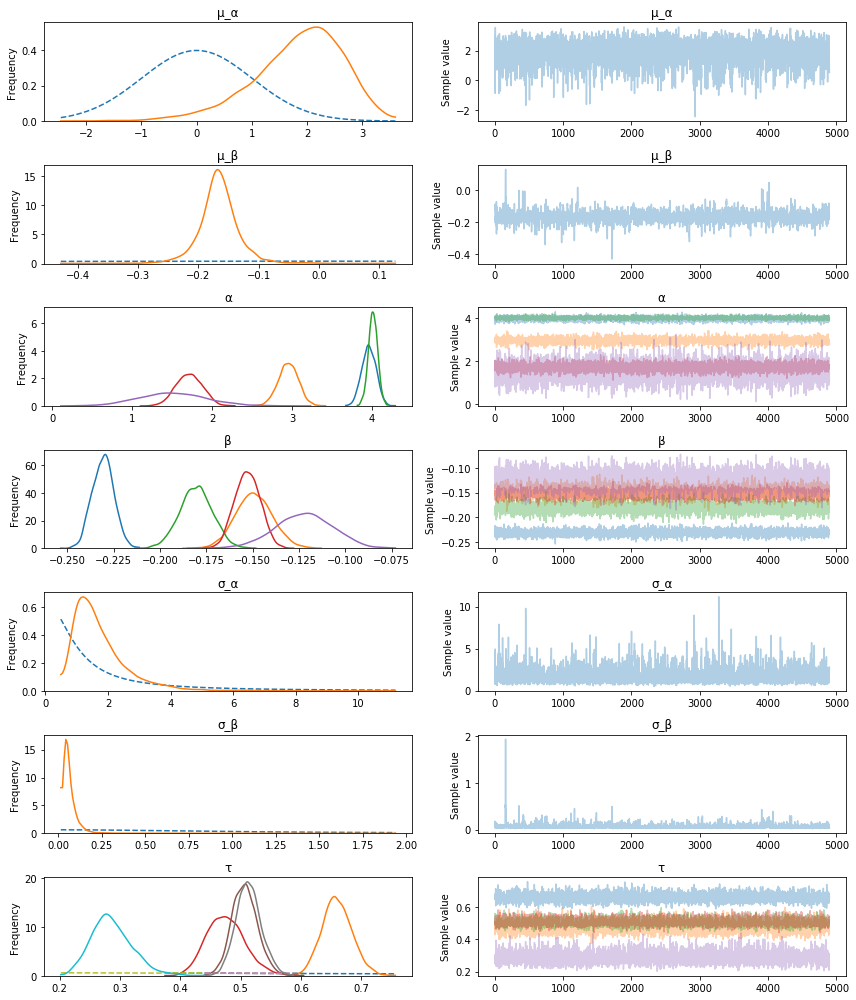

In [13]:
pm.traceplot(trace0[100:], priors=[mu_a.distribution, mu_b.distribution,
                                   None, None,
                                   sigma_a.distribution, sigma_b.distribution,
                                   tau.distribution])
plt.tight_layout()

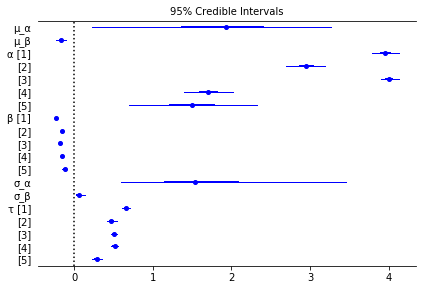

In [14]:
pm.forestplot(trace0)

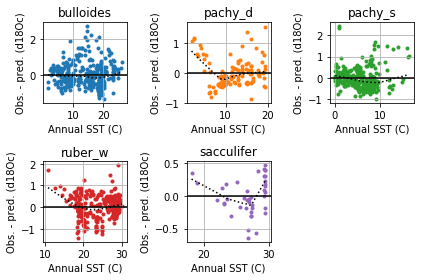

In [15]:
# Plot residuals of the median model for each spp.
# TODO(brews): This should become a function. I'm too lazy now.

for i in np.unique(idx_species):
    spp = coretops.species.unique()[i]
    coretops_sub = coretops.query("species == '{}'".format(spp))
    ax = plt.subplot(2, 3, i+1)
    spp_msk = coretops.species.unique() == spp
    alpha = np.median(trace0['α'][:, spp_msk])
    beta = np.median(trace0['β'][:, spp_msk])
#     y = alpha + beta * coretops_sub['temp_ann']
    y = alpha + beta * coretops_sub['temp_ann'] + (coretops_sub['d18osw'] - 0.27)
    resids = coretops_sub['d18oc'] - y
    resids_smoothed = sm.nonparametric.lowess(resids, coretops_sub['temp_ann'], frac=0.75)
    ax.plot(resids_smoothed[:, 0], resids_smoothed[:, 1], label='LOWESS', linestyle=':', color='black')

    ax.scatter(x=coretops_sub['temp_ann'], y=resids, marker='.', label=spp, 
               color=list(matplotlib.colors.TABLEAU_COLORS.values())[i])
    ax.axhline(y=0, color='black')
    ax.set_title(spp)
    ax.set_ylabel('Obs. - pred. (d18Oc)')
    ax.set_xlabel('Annual SST (C)')
    ax.grid(True)
plt.tight_layout()
plt.show()